<a href="https://colab.research.google.com/github/rafasuzuki/DataScience/blob/main/Meu_Projeto_Churn_Prediction_para_uma_empresa_de_Telecomunicacoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Churn Prediction

Com a facilidade que a tecnologia nos trouxe, nao é incomum pessoas terem 3 ou 4 assinaturas de plataformas de streaming de filmes, outra para musica, internet e tantos outros serviços que hoje nos parecem essenciais.  A questão é que nem sempre esses serviços atendem nossas expectativas, ou por não utilizarmos com frequência, as cancelamos. A taxa de evasão da base de clientes de uma empresa tem um nome específico, Churn Rate, ou simplesmente Churn.


<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

O monitoramento do Churn ao longo do tempo tem uma grande importância para as empresas, ela pode identificar se existe algum problema que deve ser corrigido no serviço prestado.


Utilizando alguns algoritmos de Machine Learning, podemos usar da base de dados de uma empresa e identificar potenciais cancelamentos com um tempo de antecedência, e assim promover ações direcionadas para reter tais clientes.   


## Aquisição dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento a respeito do problema.

In [1]:
# instalar Pandas Profiling 
!pip install scikit-plot -q
!pip install imbalanced-learn -q

In [25]:
# import warning filter
from warnings import simplefilter

#ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

#importando pacotes necessarios
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

#importar os dados
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

#ver as 5 primeiras entradas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Acima, visualizando as 5 primeiras entradas, podemos entender como o dataset está composto.

Logo abaixo, podemos verificar que o dataset possui 7043 entradas com 21 variáveis.

In [3]:
print('Linhas:\t\t{}'.format(df.shape[0]))
print('Colunas:\t{}'.format(df.shape[1]))

Linhas:		7043
Colunas:	21


Para entendermos o que cada variável significa, criei esse dicionário para facilitar o entendimento.


    customerID - Código de identificação do consumidor;
    gender - Gênero do consumidor;
    SeniorCitizen - Consumidor aposentado;
    Partner - Cliente casado;
    tenure - Quantos meses a pessoa é cliente da empresa;
    PhoneService - Possui serviço telefônico;
    MultipleLines - Possui múltiplas linhas telefônicas;
    InternetService - Qual provedor de serviço de internet;
    OnlineSecurity - Possui serviço de segurança online;
    OnlineBackup - Possui serviço de backup online atividado;
    DeviceProtection - Cliente possui alguma proteção de sistema;
    TechSupport - Possui serviço de suporte técnico ativdado;
    StreamingTV - Possui streaming de TV ativado;
    StreamingMovies - Possui serviço de streaming de Filmes ativado;
    Contract - Tipo do contrato do consumidor;
    PaperlessBilling - Cliente utiliza faturamento sem papel;
    PaymentMethod - Método de pagamento;
    MonthlyCharges - Pagamento mensal atual;
    TotalCharges - Valor total que o cliente pagou pelos serviços durante todo o tempo;
    Churn - Cliente abandonou o serviço.






## Análise Exploratória dos Dados

Para os primeiros passos em nosso projeto, iremos analisar a qualidade do nosso dataset. Para isso irei verificar se há dados ausentes presentes, juntamente com os nomes das variáveis, seus tipos e valores únicos.


In [4]:
print("Dados ausentes (total):\t{}\n".format(df.isnull().sum().values.sum()))
print(df.isnull().sum()/ df.shape[0])
print('\nNomes das features:\n{}\n'.format(df.columns.values))
print('Valores únicos (por coluna):\n{}\n'.format(df.nunique()))
print('Tipos de Variáveis (por coluna)\n{}'.format(df.dtypes))


Dados ausentes (total):	0

customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

Nomes das features:
['customerID' 'gender' 'SeniorCitizen' 'Partner' 'Dependents' 'tenure'
 'PhoneService' 'MultipleLines' 'InternetService' 'OnlineSecurity'
 'OnlineBackup' 'DeviceProtection' 'TechSupport' 'StreamingTV'
 'StreamingMovies' 'Contract' 'PaperlessBilling' 'PaymentMethod'
 'MonthlyCharges' 'TotalCharges' 'Churn']

Valores únicos (por coluna):
customerID          7043
gender                 2
SeniorCitizen          2
Partner             

Com os dados acima, podemos fazer algumas observações:



* A coluna `costumerID` não agrega nenhuma informação, já que é apenas um identificador para cada cliente.
* Nosso alvo se encontra na coluna `Churn`.
*   A coluna `TotalCharges` está como string mas deveria ser um `float`.
*   Outras features precisam ser codificadas para valores numéricos.

Quando tentamos converter as strings da coluna `TotalCharges`, acabamos identificando um erro.
Com isso percebemos que existem sim valores ausentes, lançados como `""`, e quando tentamos `float("")`, o interpretador retorna um erro.

Para podermos fazer a conversão, criaremos uma função para lidar com essa exceção, logo em seguida identificaremos os dados ausentes que foram encontrados, e substituiremos pelo valor da mediana da coluna.

E utilizamos do `.drop` para excluir a coluna costumerID, já que será desnecessária ao longo de todo o projeto.










In [5]:
#definindo uma função

def converter_str_float(entrada):

  try:
    return float(entrada)
  except ValueError:
    return np.nan

# criar cópia do dataframe
df_clean = df.copy()

#remover coluna costumerID
df_clean.drop('customerID', axis=1, inplace=True)

#converter as strings em TotalCharges para float
df_clean['TotalCharges'] = df_clean['TotalCharges'].apply(converter_str_float)

#verificar entradas ausentes
print('Dados ausentes em "TotalCharges" (antes):\t{}\n'.format(df_clean['TotalCharges'].isnull().sum()))

#substituir os dados ausentes pelo valor da mediana
TotalChargesMedian = df_clean.TotalCharges.median()
df_clean['TotalCharges'].fillna(TotalChargesMedian, inplace=True)



Dados ausentes em "TotalCharges" (antes):	11



Abaixo, pelo método `.describe`, podemos ver que não temos indícios da presença de outliers.


In [6]:
df_clean.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


Para reforçar essa hipótese, iremos plotar um `boxplot` para verificar a distribuição dos valores nas features `MonthlyCharges` e `TotalCharges`.

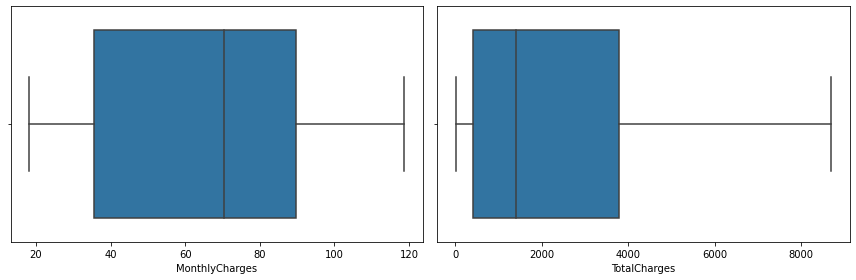

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.boxplot(df_clean['MonthlyCharges'], ax=ax[0])
sns.boxplot(df_clean['TotalCharges'], ax=ax[1])
plt.tight_layout()



Como podemos ver logo abaixo, a quantidade de `No` é superior a classe `yes` para a feature `Churn`.

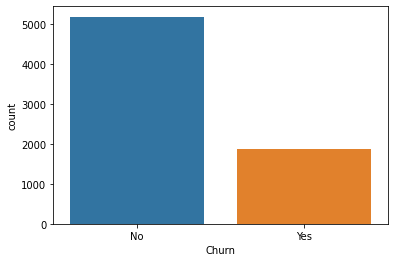

In [9]:
sns.countplot(df.Churn);

Para encerrar nossa análise exploratória, vamos dar um destaque especial a categoria `tenure` (meses em que a pessoa é cliente da empresa).

Com o gráfico abaixo podemos observar que a maioria dos clientes em nosso dataset são novos assinantes dos serviços da empresa.

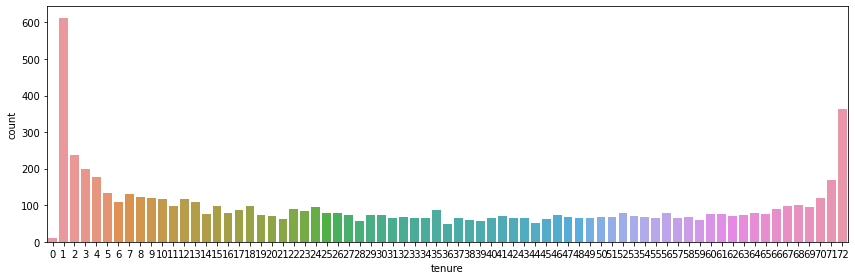

In [8]:
fig, ax = plt.subplots(figsize=(12,4))
sns.countplot(df['tenure'])
plt.tight_layout()

Com o resultado acima, criei um histograma da variável `tenure` em relação ao `Churn`, e podemos observar que a maioria dos cancelamentos do serviço da empresa se da justamente por clientes com poucos meses de adesão.

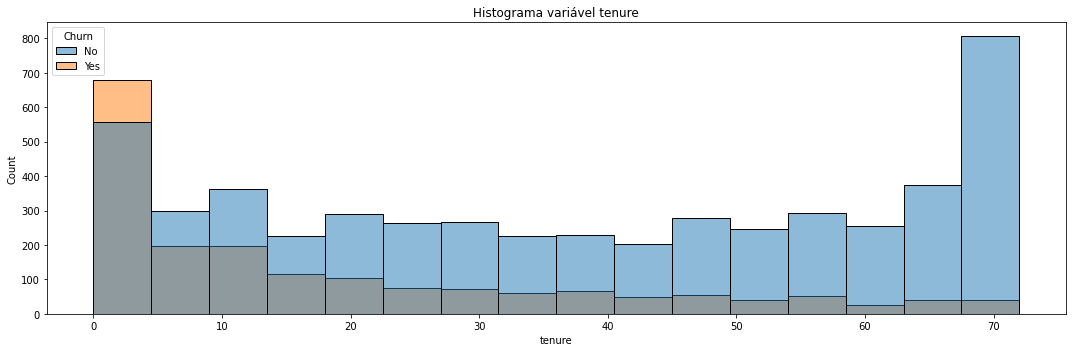

In [10]:
#instanciando o objeto
fig, ax = plt.subplots( nrows = 1, ncols = 1, figsize = (15,5))

#Criando um histograma para a variável tenure
sns.histplot(data = df_clean, x = 'tenure', ax = ax, hue = "Churn")

#Setando o título do gráfico
ax.set_title("Histograma variável tenure")

#Exibindo o gráfico
plt.tight_layout()


Alguns insights tirados da nossa análise para a variável `tenure`.


*   Quanto maior o tempo de adesão do serviço, menor a probabilidade dele abandonar o mesmo.
*   Como a maioria do Churn vem de clientes que aderiram recentemente o serviço, assumimos a premissa de que o contrato de serviço deles deve ser de curta duração. O que torna a chance do Churn maior.



## Preparar os Dados

Nesta etapa de preparação dos dados, será realizado um pré-processamento básico, apenas com a finalidade de construir um modelo base. 

As features que continham 2 labels únicos, serão processadas usando-se o `LabelEncoder`. Vale lembrar que isso inclui a variável alvo `Churn`. Na sequência, serão separadas as variáveis numéricas das categóricas. As categóricas serão transformadas em variáveis dummy, para permitir a sua utilização em todos os modelos.

In [11]:
# pre processar as variaveis
binary_var = df_clean.nunique()[df_clean.nunique() == 2].keys().tolist()
num_var = [col for col in df_clean.select_dtypes(['int','float']).columns.tolist() if col not in binary_var]
cat_var = [col for col in df_clean.columns.tolist() if col not in binary_var + num_var]

#criando copia do df
df_proc = df_clean.copy()

#Label Encoding para as variaveis binarias
le = LabelEncoder()
for i in binary_var:
  df_proc[i] = le.fit_transform(df_proc[i])

#Encoding para colunas categoricas com multiplas classes
df_proc = pd.get_dummies(df_proc, columns=cat_var)

#5 primeiras entradas do novo dataframe
df_proc.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


## Modelo de Machine Learning
Como ja realizamos o processamento de dados na etapa anterior, ja podemos utilizá-los para nossos modelos de Machine Learning.
Para isso, iremos separar os dados em conjuntos de treino e teste.

In [23]:
# separando a feature matrix da target vector
X = df_proc.drop('Churn', axis=1)
y = df_proc['Churn']

# dividir os dados entre Treino e Test
X_train, X_test, y_train, y_test = train_test_split(X, y)

Irei usar a cross-validation para estimar o erro da baseline e dos modelos iniciais. Para facilitar e melhorar o código, foi criada uma função `val_model`. A métrica utilizada para avaliação será `recall`.

In [1]:
def val_model(X, y, clf, quite=False):
    
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if quite == False:
        print("Recall: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std()))
    
    return scores.mean()

Para a baseline inicial, usarei o Random Forest, sem nenhuma alteração nos parâmetros.

In [14]:
# baseline para ver o desempenho
rf = RandomForestClassifier()
score_baseline = val_model(X_train, y_train, rf)

Recall: 0.49 (+/- 0.01)


Uma vez que temos um baseline para comparar se os ajustes melhoram ou pioram o desempenho do modelo, irei realizar o balanceamento dos dados e ver como isso irá impactar.

A técnica escolhida foi Under Sampling, após alguns teste de desempenho das outras. Seguindo recomendações de algumas literaturas, os dados serão padronizados antes de usar essa técnica de balanceamento.

Lembrando, é importante que o balanceamento aconteca apenas com os dados de treino. Os dados de teste devem permanecer intocáveis.


In [15]:
# padronizar os dados
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

Utilizarei a validação cruzada em vários modelos, com o objetivo de encontrar o melhor desempenho entre eles. Serão usados apenas os dados de treino. Os modelos escolhidos são:

* Random Forest
* Decision Tree
* Stochastic Gradient Descent
* SVC
* Regressão Logística
* LightGBM

In [16]:
# instanciar modelos
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

model = []
recall = []
# avaliar o desempenho (recall)
for clf in (rf, dt, sgdc, svc, lr, xgb, lgbm):
    model.append(clf.__class__.__name__)
    recall.append(val_model(X_train_rus, y_train_rus, clf, quite=True))

pd.DataFrame(data=recall, index=model, columns=['Recall'])

,Recall
RandomForestClassifier,0.746123
DecisionTreeClassifier,0.667359
SGDClassifier,0.734275
SVC,0.791829
LogisticRegression,0.798164
XGBClassifier,0.798162
LGBMClassifier,0.761594


Apesar da Regressão Logística ter um desempenho brevemente melhor, optarei pelo XGBoost, pois possui um melhor tuning de parâmetros.

## Otimização dos Hiperparâmetros

XGBoost possui inúmeros parâmetros. Alguns afetam mais a qualidade do modelo, outros menos. Uma boa prática é definir uma taxa de aprendizado e número de estimadores, realizar tuning de outros parâmetros e, no final, checar outras taxas de aprendizado.

Abaixo, irei ajustar o número de estimadores. O modelo foi instanciado com a `learning_rate=0.1`.

In [17]:
xgb = XGBClassifier(learning_rate=0.1)

param_grid = {
    'n_estimators':range(0,1000,50),
}

#identificar melhor parametro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

#ver resultados
print('Melhor: {} para {}'.format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8003151777799665 para {'n_estimators': 50}


Com o número de estimadores igual a 50, realizarei a busca pelos parâmtros `max_depth` e `min_child_weight`.

In [18]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=50)

param_grid = {
    'max_depth':range(1,8,1),
    'min_child_weight':range(1,5,1)
}

#identificar melhor parametro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

#ver resultados
print('Melhor: {} para {}'.format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8072737122032896 para {'max_depth': 1, 'min_child_weight': 1}


Obtidos os valores de `max_depth=1` e `min_child_weight=1`, irei otimizar o parâmetro `gamma`.

In [19]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=50, max_depth=1, min_child_weight=1)

param_grid = {
    'gamma':[i/10.0 for i in range(0,5)]
}

#identificar melhor parametro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

#ver resultados
print('Melhor: {} para {}'.format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8037722840539743 para {'gamma': 0.0}


Por fim, obtido `gamma=0`, vou testar quatro valores para a `learning_rate` e ver qual oferece o melhor resultado.

In [21]:
xgb = XGBClassifier(n_estimators=50, max_depth=1, min_child_weight=1, gamma=0.0)

param_grid = {
    'learning_rate':[0.001,0.01,0.1,1]
}

#identificar melhor parametro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

#ver resultados
print('Melhor: {} para {}'.format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8860780065005416 para {'learning_rate': 0.001}


Fato é que uma taxa de aprendizado menor, conseguiu melhorar o desempenho do modelo XGBoost, considerando `recall` como sendo a única métrica de importância (premissa assumida por este autor).

Agora, treina-se o modelo em cima do dataset de treino completo, e verifica-se o desempenho final em cima dos dados de teste, no seu primeiro contato com esse sub-conjunto que havia sido preservado.

              precision    recall  f1-score   support

           0       0.94      0.56      0.70      1308
           1       0.41      0.89      0.56       453

    accuracy                           0.64      1761
   macro avg       0.67      0.72      0.63      1761
weighted avg       0.80      0.64      0.66      1761

AUC: 0.7250



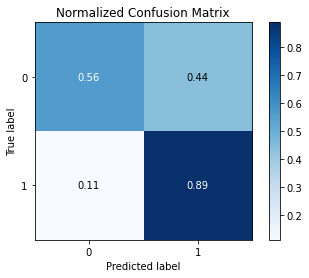

In [26]:
#modelo final
xgb = XGBClassifier(learning_rate=0.001, n_estimators=50, max_depth=1, min_child_weight=1, gamma=0.0)
xgb.fit(X_train_rus, y_train_rus)

# fazer a previsao
X_test = scaler.transform(X_test)
y_pred = xgb.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

#imprimir a area sob a curva
print('AUC: {:.4f}\n'.format(roc_auc_score(y_test, y_pred)))

#plotar matriz de confusao
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

## Conclusões

Os dados de testes não haviam sido passados para o modelo ainda. No entanto, ele manteve um desempenho próximo àquele estimado anteriormente, graças a um bom trabalho de otimização nos parâmetros.

Existem outros parâmetros em que podemos fazer mais ajustes, afim de refinar o resultado obtido com o XGBoost.

Também podemos tentar outras técnicas de balanceamento de dados e de Machine Learning como feature engineering e feature selection, em busca de melhores resultados.